# Understanding and Implementing Convolutional Neural Networks (CNNs)

## Introduction
Before the implementation, we would like to stablish an overview of the  NN architecture and  explore their operation, data flow, and the mechanisms that enable them to perform image classification. Understanding these concepts will help us implement the network more effectively.

## Architecture overview
Below is the architecture diagram for Model 2 (this work will contain 3 models), which we will analyze in detail. The diagram shows a simplified representation of the layer transformations, though the actual processes within the convolutional layer are more complex.




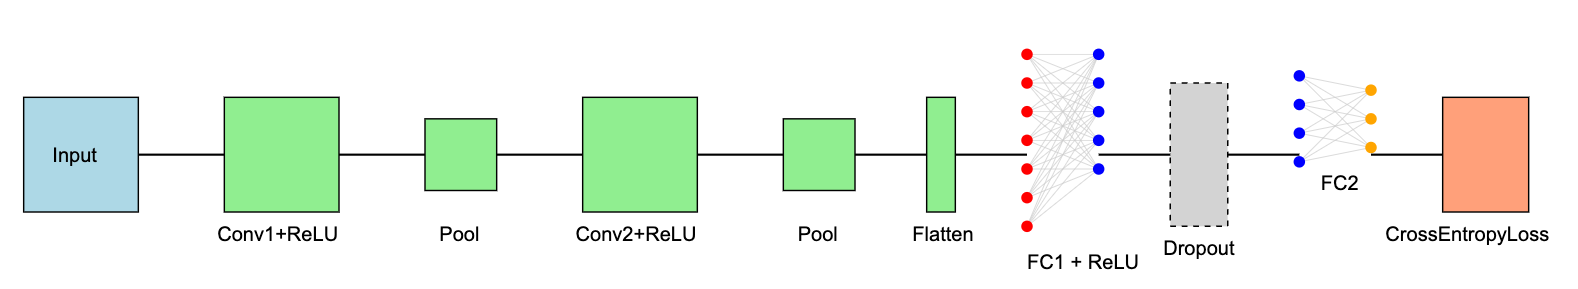

Our model will consist off:

1. Convolutional layers for feature extraction
2. Fully connected layers for classification

This neural network architecture introduces three key elements that were not present in our previous fully connected neural net: convolution, pooling, and dropout. We will explain each of these transformations in the next section.

## The convolutional layers

Convolutional layers are the fundamental building blocks of a CNN. They perform feature extraction through:
$$Z=X*W + b$$

Similar to our previous implementation of an MLP, we have a set of weights and biases, but instead of matrix multiplication, the * symbol represents convolution. This convolution works as a feature detector that scans across the input image:
$$y = x * w \to y[i] = \sum_{k=-\infty}^{+\infty} x[i + k] w[k]$$

We must note about this formula: While this is PyTorch's implementation of convolution, it is technically called cross-correlation. Mathematically, the only difference is that the kernel is not flipped during the operation.

Each convolution kernel (`W`) learns to detect specific patterns—early layers identify simple features like edges and textures, while deeper layers combine these to detect more complex patterns like shapes and object parts. The number of layers is a hyperparameter, and its selection should consider factors such as the problem being solved and computational efficiency. This feature extraction capability makes CNNs particularly effective for image processing tasks.




>  💡***Real-world Analogy***: Think of convolution kernels like chemical reagents in a laboratory. Just as reagents react with specific substances in a water sample to produce color changes, convolution kernels react with specific patterns in an image to produce feature maps.


The result of our convolution is pass through our activation function (ReLU function) which will add a non-linearity that will help us to recognize complex platterns.

## Pooling
We are incorporating a new transformation concept: pooling. This dimension reduction operation reduces the spatial size of feature maps while preserving the most important information. Think of it as creating a lower-resolution version of the feature maps that retains the essential patterns. In our architecture, we use Max Pool, which takes a small window (typically 2×2) and keeps only the maximum value in that window. This approach is particularly effective for image tasks because it preserves the strongest detected features. Here is an example with a 2×2 window:
```python
Input:          Max Pool Result:
2  5  3  1
8  4  2  3      8  3
1  7  4  2  ->  7  6
3  6  6  
```

## Fully connected layers

The second part of our architecture transforms these extracted features into class predictions through fully connected layers.  After the convolutional section, the Flatten layer converts our 2D feature maps into a 1D vector that can be processed by the fully connected layers.  This becomes the architecture of our previous exercise for our fully connected neural network. Now we will use:

$$Z=X·W + b$$

Note that we now use matrix multiplication to calculate the net input Z. As in our previous classifier, we first apply the ReLU activation function, then pass the result through dropout.

## Dropout

Dropout is a regularization technique that helps prevent overfitting by randomly deactivating neurons during training. During each training iteration, dropout temporarily removes a proportion of neurons (typically 50% with p=0.5) from the network. This random deactivation makes the network more robust and improves its ability to generalize to new data.

## Final Layer

The final fully connected layer will produce the logits for each class. These logits are passed to PyTorch's CrossEntropyLoss function, which combines softmax activation (specifically  LogSoftmax) and negative log likelihood loss (NLLLoss) to compute the loss value that drives backpropagation.

### A reflection about the interpretation of the weights and biases

Our model contains two distinct types of weights and biases, each serving a unique purpose:

In the convolutional layers, weights form convolution kernels that learn to recognize complex visual patterns. These kernels are computationally efficient because they're much smaller than the input image and can be applied repeatedly across different positions.

In the fully connected layers, weights and biases create multidimensional decision boundaries that separate different classes. These boundaries help combine the extracted features to distinguish between classes effectively.

Through backpropagation, both types of parameters are continuously refined to enhance the network's image recognition and classification capabilities.

## Dataflow
As an exercise to  further enhance our understanding, we will run a forward process, to examine the transformations that takes place at each stage of our process.

**Input data**

We are using the CIFAR10 dataset, with a batch size of 64. Thus our initial input’s will have a shape of `[batch_size, rgb_channels, width, height] = [64,3,32,32]`

**First convolution + ReLU + Pooling**

Since we will define our convolutional layer as:

```python
nn.Conv2d(
	in_channels=3,
	out_channels=32,
	kernel_size=3,
	padding=1
)
x = self.pool(F.relu(self.conv1(x)))
```

Our kernel will have a shape of  **[out_channels, in_channels, kernel_width, kernel_height]**, this is `w= [32, 3, 3, 3]`. Where:

- `out_channels` represents 32 different feature maps
- `in_channels` - matching the RGB input channels
- `kernel_width` - the spatial width of the kernel
- `kernel_height` - the spatial height of the kernel

The result of our first convolution will have a shape  `[64, 32, 32, 32]`, where:

- The first dimension `[64]` is the batch size. It remains unchanged from input as we process each image independently
- The second dimension `[32]` will match the number of output channels specified in our `Conv2d` layer, which are the number of feature maps.
- Third & Fourth dimensions `[32, 32]` are the spatial dimensions (height, width) of each feature map. They remain 32×32 because we used padding=1 which preserves the spatial dimensions as shown by our formula:

$$o = \left\lfloor\frac{n + 2p - m}{s}\right\rfloor + 1$$

Using the parameters for our model we have:

```python
output_size = ((input_size + (2 * padding) - kernel_size) / stride) + 1
           = ((32 + (2 * 1) - 3) / 1) + 1
           = ((32 + 2 - 3) / 1) + 1
           = (31 / 1) + 1
           = 32
```

After convolution, a ReLU activation function will be applied. But this preserves the dimensions: `[64, 32, 32, 32]`.

**Max Pooling**

Max pooling reduces the dimensions of the image. Applying pooling is equivalent to creating a smaller version of our previous feature map. This affects only the dimensions that represent the height and with of the image. With our max pool we reduce the dimensions by half, transforming from `[64, 32, 32, 32]` to `[64, 32, 16, 16]`

**Second Convolutional layer+ ReLU+Pooling**

Our second convolutional layer is defined as below:

```python
self.conv2 = nn.Conv2d(
	in_channels=32,  # we need to mach the output channels from previous input
	out_channels=64, # Define the number of output channels
	kernel_size=3,   
	padding=1
)
```

Notice it is expecting 32 input channels and will output 64 feature maps. As before, we should remember that the ReLU function preserves the original size of its input when applied. Additionally, we will apply another max pooling operation that cuts the width and height dimensions in half.

As result, we will go from shape `[64, 32, 16, 16]` to `[64, 64, 8, 8]`.

- First dimension `[64]` preserves the original batch size
- The second dimension will be `[64]` per the defined `out_channels`.
- The third and fourth dimension `[8,8]` are the result of applying a max pooling with `kernel` size 2 and `stride` 2.

**Flattening and Fully connected layer + ReLU**

The flatten operation will transform our data’s shape from `[64, 64, 8, 8]`to `[64, 64 * 8 * 8] =[64, 4096]`.  The fully connected layer will implement the matrix multiplication:

$$Z=X·W+b$$

Where our `W` will be `[4096, 128]`. Matrix multiplication will transform our shapes as:

```bash
    Z_shape =   X_shape  ·   W_shape
[64, 128]   = [64, 4096] · [4096, 128]
```

After applying the ReLU activation function, our data will have a shape of `[64, 128]`.

**Dropout + fully Connected Layer and CrossEntropyLoss**

The Dropout Layer (`self.dropout(p=0.5)`) will randomly set to zero the 50%  of the elements. The shape of our data will remain the same `[64, 128]`. Our second fully connected layer will multiply the following shapes:`[64, 128] ·[128, 10]`,

```bash
 Z_shape =  X_shape  ·   W_shape
[64, 10] = [64, 128] · [128, 10]
```

Our final shape will be: `[64,10]`, where the second dimension `[10]` will have the same number of the clases in our dataset.

Each value in the final output represents the raw logit score for each class. These logits will be used by the `CrossEntropyLoss` to calculate the loss and initiate the backward propagation.

**Summary**

``` python
input: [64,3,32,32] ->
Conv1+ReLU+Pool -> [64,32,16,16] ->
Conv2+ReLU+Pool -> [64,64,8,8] ->
Flatten -> [64,4096] ->
FC1+ReLU -> [64,128] -> Dropout -> [64,128] ->  
FC2 -> [64,10] -> Softmax -> [64,10]
```

# Implementation

## Data preparation and exploration

In this section we will implement some utility functions that will help us with:
1. Downloading the CIFAR10 dataset
2. Inspect the contents of our dataset
3. Visualize some of the images in our dataset
4. Setting up device agnostic code (so our model can run on CPU or GPU if it's available)

In [28]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

import tempfile
import os
from tabulate import tabulate


In [29]:
def setup_cifar10_dataloaders(batch_size=64):
    """
    Sets up CIFAR-10 dataset with train, validation, and test dataloaders.

    Args:
        batch_size (int): Size of mini-batches. Defaults to 64.

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    # Set up constants
    DATA_PATH = tempfile.gettempdir()
    NUM_TRAIN = 50000
    NUM_VAL = 5000

    # Define data transformations
    transform_cifar = T.Compose([
        T.ToTensor(),
        T.Normalize(
            mean=[0.491, 0.482, 0.447],
            std=[0.247, 0.243, 0.261]
        )
    ])

    # Create train dataset and loader
    cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                                    transform=transform_cifar)
    train_loader = DataLoader(cifar10_train, batch_size=batch_size,
                             sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

    # Create validation and test datasets from test split
    cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                                  transform=transform_cifar)
    val_loader = DataLoader(cifar10_val, batch_size=batch_size,
                           sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

    cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                                   transform=transform_cifar)
    test_loader = DataLoader(cifar10_test, batch_size=batch_size,
                            sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

    return train_loader, val_loader, test_loader


def inspect_dataloader(loader):
    """
    Inspects and prints information about a PyTorch dataloader including batch size,
    tensor shapes, and value ranges of the first batch.

    Args:
        loader (torch.utils.data.DataLoader): The dataloader to inspect
    """
    # Get the first batch
    x, y = next(iter(loader))

    # Prepare data for tabulation
    table_data = [
        ["Batch size", loader.batch_size],
        ["Images tensor shape", x.shape],
        ["Labels tensor shape", y.shape],
        ["First few labels", y[:5].tolist()],
        ["Image value range", f"min: {x.min():.3f}, max: {x.max():.3f}"]
    ]

    # Print formatted table
    print(tabulate(table_data,
                  headers=["Property", "Value"],
                  tablefmt="grid",
                  colalign=("left", "left")))

def setup_device():
    """
    Determines and returns the best available device (GPU/CPU) for PyTorch computations.

    Returns:
        torch.device: The device to be used ('cuda' if GPU is available, 'cpu' otherwise)
    """
    # Check for GPU availability and set the device accordingly
    if torch.cuda.is_available():
        device = torch.device('cuda')  # Use GPU if available
    else:
        device = torch.device('cpu')   # Fall back to CPU if no GPU

    # Print which device will be used for computations
    print(f"Using device: {device}")

    return device

def plot_figure(image, dpi=25):
    """
    Display a tensor image using matplotlib.

    Args:
        image (torch.Tensor): Image tensor of shape (channels, height, width)
        dpi (int): Dots per inch - controls image display size
    """
    plt.figure(dpi=dpi)
    plt.imshow(image.permute(1, 2, 0))  # Using permute instead of np.transpose
    plt.axis('off')
    plt.show()

def display_random_cifar10_image(test_loader):
    """
    Displays a random image from the CIFAR-10 dataset along with its class name.

    Args:
        test_loader (torch.utils.data.DataLoader): The test data loader containing CIFAR-10 images
    """
    # Get list of class names from the test dataset
    classes = test_loader.dataset.classes  # CIFAR-10 has 10 classes

    # Randomly sample an image from the test dataset
    rnd_sample_idx = np.random.randint(len(test_loader.dataset))

    # Print the class name of the sampled image
    print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')

    # Get the image tensor from the dataset
    image = test_loader.dataset[rnd_sample_idx][0]  # [0] gets image, [1] would get label

    # Normalize image to [0,1] range for proper display
    image = (image - image.min()) / (image.max() - image.min())

    # Display the normalized image
    plot_figure(image)

def plot_cifar10_grid(loader):
    """
    Creates a grid visualization of CIFAR-10 images, showing 8 examples for each class.

    Args:
        loader (torch.utils.data.DataLoader): DataLoader containing CIFAR-10 dataset
    """
    # Get list of class names from dataset
    classes = loader.dataset.classes

    # Number of samples to show per class
    total_samples = 8

    # Create figure with appropriate size
    plt.figure(figsize=(15,15))

    # Iterate through each class
    for label, sample in enumerate(classes):
        # Find all indices where the target matches current label
        class_idxs = np.flatnonzero(label == np.array(loader.dataset.targets))

        # Randomly sample 'total_samples' number of images from this class
        sample_idxs = np.random.choice(class_idxs, total_samples, replace=False)

        # Plot each sampled image
        for i, idx in enumerate(sample_idxs):
            # Calculate position in the grid
            plt_idx = i*len(classes) + label + 1

            # Create subplot at calculated position
            plt.subplot(total_samples, len(classes), plt_idx)

            # Display image
            plt.imshow(loader.dataset.data[idx])
            plt.axis('off')  # Remove axes for cleaner visualization

            # Add class name as title for first row only
            if i == 0:
                plt.title(sample)

    # Display the entire grid
    plt.show()

Now let's use our utility functions to prepare and examine our dataset

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Train loader:
+---------------------+-----------------------------+
| Property            | Value                       |
+=====================+=============================+
| Batch size          | 64                          |
+---------------------+-----------------------------+
| Images tensor shape | torch.Size([64, 3, 32, 32]) |
+---------------------+-----------------------------+
| Labels tensor shape | torch.Size([64])            |
+---------------------+-----------------------------+
| First few labels    | [4, 2, 0, 4, 6]             |
+---------------------+-----------------------------+
| Image value range   | min: -1.988, max: 2.132     |
+---------------------+-----------------------------+


One Random image from our test dataset
La imagen muestreada representa un: automobile


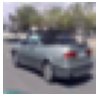



Grid of images from our database, showing 8 examples for each class


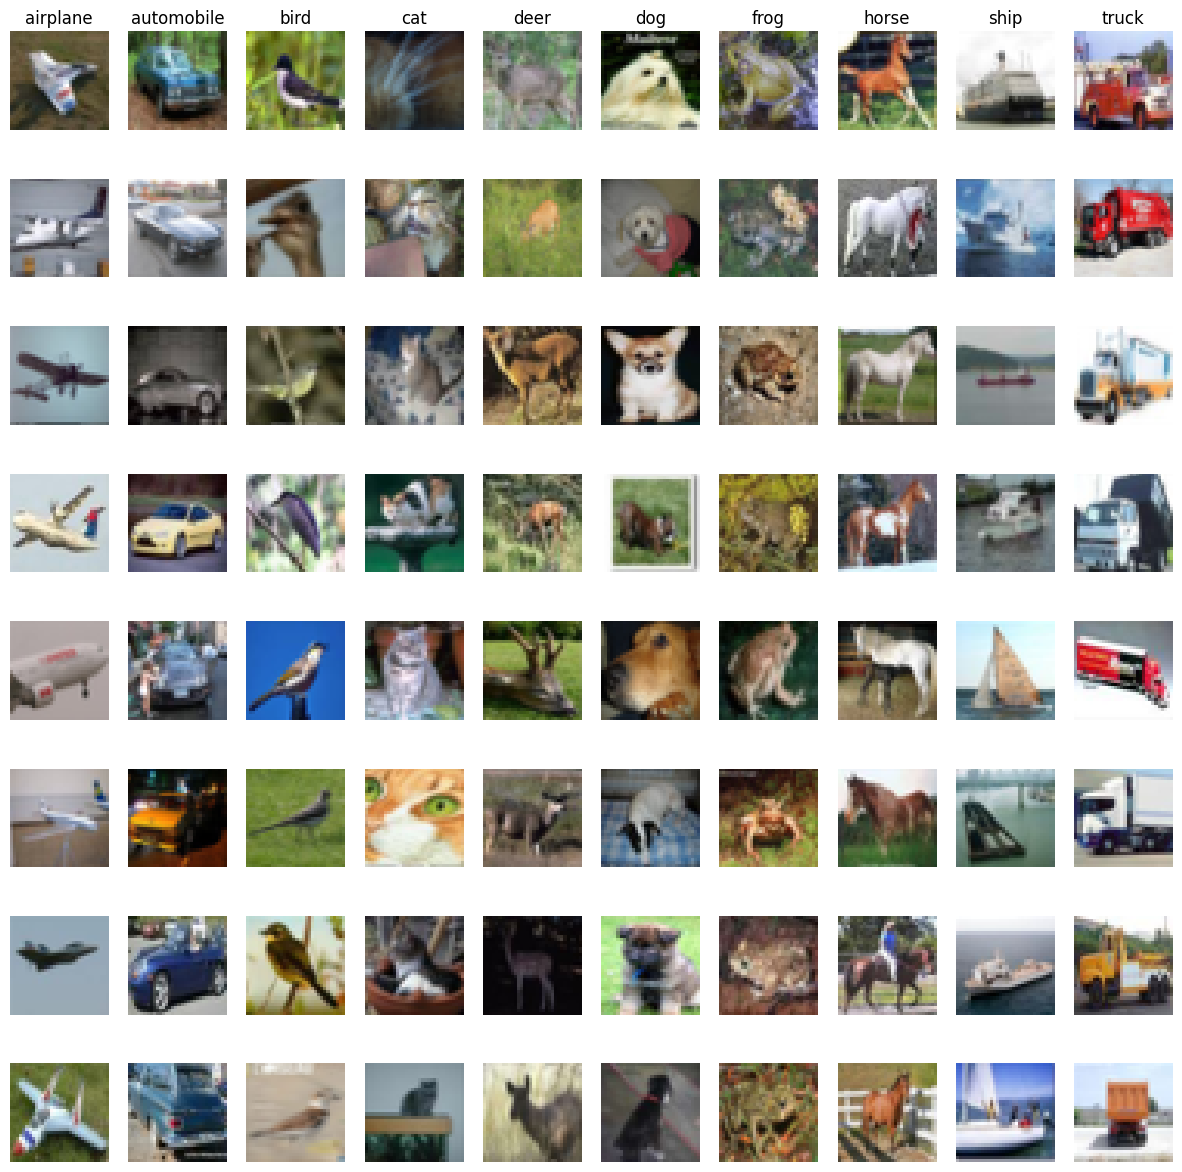

In [30]:
# Download the CIFAR10 dataset and create dataloaders.
# It is important to understand the  Data loaders. They combine a dataset and a sampler,
# and provides an iterable over the given dataset.
train_loader, val_loader, test_loader = setup_cifar10_dataloaders()

# inspect one of the dataloaders
print("\n")
print("\033[1mTrain loader:\033[0m")
inspect_dataloader(train_loader)

# Lets take one random image from our test dataset and display it
print("\n")
print("\033[1mOne Random image from our test dataset\033[0m")
display_random_cifar10_image(test_loader)

# Let's display a grid of CIFAR10 images
print("\n")
print("\033[1mGrid of images from our database, showing 8 examples for each class\033[0m")
plot_cifar10_grid(test_loader)

In [31]:
# Set up device (GPU if available, CPU otherwise) for PyTorch computations
device = setup_device()

Using device: cuda


## Training and accuracy
Before constructing our models, let's implement our functions for training and accuracy

In [32]:
def accuracy(model, loader):
    """Calculate accuracy of the model on a given dataset.

    Parameters
    ----------
    model : nn.Module
        The model to evaluate
    loader : DataLoader
        The dataloader for the dataset

    Returns
    -------
    float
        Accuracy percentage
    """
    # Switch model to evaluation mode - disables dropout, batch normalization uses running statistics
    model.eval()

    # Initialize counters for correct predictions and total samples
    correct = 0
    total = 0

    # Disable gradient computation to save memory and speed up evaluation
    with torch.no_grad():
        # Use the training data loader to iterate through the dataset
        for inputs, labels in loader:
            # Make sure we are using the device we setup before
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: get model predictions
            outputs = model(inputs)

            # Get the predicted class (index of maximum value) for each sample
            # outputs.data has shape [batch_size, num_classes]
            # predicted will have shape [batch_size] containing the predicted class indices
            _, predicted = torch.max(outputs.data, 1)

            # Update total number of samples processed
            total += labels.size(0)

            # Update number of correct predictions
            # (predicted == labels) creates a boolean tensor
            # .sum() counts True values (correct predictions)
            # .item() converts the tensor to a Python number
            correct += (predicted == labels).sum().item()

    # Calculate and return accuracy percentage
    return 100 * correct / total

def train(model, optimiser, epochs=100):
    """This function will exectue the training of our neural network models

    Parameters
    ----------
    model : nn.Module
        The model to train
    optimiser : torch.optim.Optimizer
        The optimizer to use
    epochs : int, optional (default=100)
        Number of epochs to train

    """
    # The criterion is a parameter that declares an specific class from pytorch that
    # receives the logits and the labels and computes the loss. CrossEntropyLoss is
    # standard for classification tasks.
    criterion = nn.CrossEntropyLoss()

    # Move model to appropriate device (GPU if available, else CPU)
    model.to(device)

    # Main training loop
    for epoch in range(epochs):
        # Set model to training mode (enables dropout, batch norm updates, etc.)
        model.train()
        loss = 0.0

        # Initiate training using the training data loader-
        for inputs, labels in train_loader:
            # Lets make sure we are using the device we setup before
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset gradients for this batch
            optimiser.zero_grad()

            # Forward pass: compute model predictions
            outputs = model(inputs)

            # Compute loss between predictions and true labels
            loss = criterion(outputs, labels)

            # Backward pass: compute gradients
            loss.backward()

            # Update model parameters using optimizer
            optimiser.step()

            # Accumulate batch loss for epoch statistics
            loss += loss.item()

        # Calculate performance metrics for this epoch
        avg_loss = loss / len(train_loader)
        train_acc = accuracy(model, train_loader)
        val_acc = accuracy(model, val_loader)

        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Loss: {avg_loss:.4f}')
        print(f'Train Accuracy: {train_acc:.2f}%')
        print(f'Validation Accuracy: {val_acc:.2f}%')
        print('-' * 50)

# Linear model - base model #1
## Architecture of the model:
- 1st layer: Fully Conected  + ReLU as its activation function
- Exit layer: Fully Conected (fc1). This is the output layer.


In [33]:
class LinearModel(nn.Module):
    """Two-layer linear classifier for CIFAR-10 with ReLU activation."""
    def __init__(self):
        super(LinearModel, self).__init__()
        # Calculate input features: 3 channels * 32 height * 32 width
        self.input_size = 3 * 32 * 32
        self.hidden_size = 512  # Size of hidden layer
        self.output_size = 10   # CIFAR-10 has 10 classes

        # First linear layer followed by ReLU
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.relu = nn.ReLU()
        # Second linear layer for final output
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        # Flatten the input: (batch_size, channels, height, width) -> (batch_size, channels*height*width)
        x = x.view(-1, self.input_size)
        # First linear layer + ReLU
        x = self.relu(self.fc1(x))
        # Second linear layer
        x = self.fc2(x)
        return x

# Create model and optimizer
model1 = LinearModel()
optimiser = torch.optim.Adam(model1.parameters(), lr=0.001)

In [34]:
#Train Model #1
train(model1, optimiser, 10)

Epoch [1/10]
Loss: 0.0046
Train Accuracy: 45.56%
Validation Accuracy: 43.60%
--------------------------------------------------
Epoch [2/10]
Loss: 0.0042
Train Accuracy: 50.66%
Validation Accuracy: 47.72%
--------------------------------------------------
Epoch [3/10]
Loss: 0.0035
Train Accuracy: 51.83%
Validation Accuracy: 46.40%
--------------------------------------------------
Epoch [4/10]
Loss: 0.0036
Train Accuracy: 56.06%
Validation Accuracy: 49.14%
--------------------------------------------------
Epoch [5/10]
Loss: 0.0020
Train Accuracy: 58.45%
Validation Accuracy: 50.30%
--------------------------------------------------
Epoch [6/10]
Loss: 0.0043
Train Accuracy: 58.09%
Validation Accuracy: 48.88%
--------------------------------------------------
Epoch [7/10]
Loss: 0.0028
Train Accuracy: 62.09%
Validation Accuracy: 50.54%
--------------------------------------------------
Epoch [8/10]
Loss: 0.0033
Train Accuracy: 64.16%
Validation Accuracy: 51.04%
---------------------------

In [43]:
# Let's verify how the model performs with our test data
test_acc1 = accuracy(model1, test_loader)
print(f"\033[1mAccuracy with test data for Model #1: {test_acc1:.2f}%\033[0m")

Accuracy with test data for Model #1: 51.12%


# Convolutional Neural Network Model #2
## Architecture of the model:
- 1st layer: Convolutional + ReLU as its activation function
- MaxPooling (k=2, s=2)
- 2nd layer: Convolutional + ReLU as its activation function
- MaxPooling (k=2, s=2)
- Flatten the tensor before entering the 3rd layer
- 3d layer: Fully Connected + ReLU as its activation function + MaxPooling (k=2, s=2)
- Apply Dropout before entering the exit layer
- Exit layer: Fully Connected


In [36]:
class ModelCNN1(nn.Module):
    def __init__(self):
        super(ModelCNN1, self).__init__()
        # First convolutional layer: 3 input channels (RGB), 32 output channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        # Second convolutional layer: 32 input channels, 64 output channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # First fully connected layer (64 channels * 8 * 8 from previous layers)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        # Output layer (10 classes for CIFAR10)
        self.fc2 = nn.Linear(128, 10)
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First conv layer + ReLU + pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Second conv layer + ReLU + pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        # First fully connected layer + ReLU
        x = F.relu(self.fc1(x))
        # Apply dropout
        x = self.dropout(x)
        # Output layer
        x = self.fc2(x)
        return x

# Initialize the model and optimizer
modelCNN1 = ModelCNN1()
learning_rate = 0.001
optimiser = optim.Adam(modelCNN1.parameters(), lr=learning_rate)
epochs = 10  # You can adjust this value

In [37]:
# Let's proceed with the training
train(modelCNN1, optimiser, epochs)

Epoch [1/10]
Loss: 0.0037
Train Accuracy: 60.85%
Validation Accuracy: 60.60%
--------------------------------------------------
Epoch [2/10]
Loss: 0.0019
Train Accuracy: 65.98%
Validation Accuracy: 64.42%
--------------------------------------------------
Epoch [3/10]
Loss: 0.0040
Train Accuracy: 71.07%
Validation Accuracy: 68.00%
--------------------------------------------------
Epoch [4/10]
Loss: 0.0032
Train Accuracy: 74.14%
Validation Accuracy: 69.16%
--------------------------------------------------
Epoch [5/10]
Loss: 0.0020
Train Accuracy: 76.16%
Validation Accuracy: 70.40%
--------------------------------------------------
Epoch [6/10]
Loss: 0.0018
Train Accuracy: 79.08%
Validation Accuracy: 70.86%
--------------------------------------------------
Epoch [7/10]
Loss: 0.0026
Train Accuracy: 80.53%
Validation Accuracy: 71.06%
--------------------------------------------------
Epoch [8/10]
Loss: 0.0012
Train Accuracy: 80.60%
Validation Accuracy: 70.82%
---------------------------

In [44]:
# Let's verify how the model performs with our test data
test_acc2 = accuracy(modelCNN1, test_loader)
print(f"\033[1mAccuracy with test data for Model #2: {test_acc2:.2f}%\033[0m")

Accuracy with test data for Model #2: 72.46%


## Convolutional Neural Network Model #3 (Sequential with Batch normalization)
## Architecture of the model:
- 1st layer: Convolutional + Batch Normalization + ReLU as its activation function
- 2nd layer: Convolutional + Batch Normalization + ReLU as its activation function
- MaxPooling (k=2, s=2)
- 3d layer: Convolutional + Batch Normalization + ReLU as its activation function
- 4th layer: Convolutional + Batch Normalization + ReLU as its activation function
- MaxPooling (k=2, s=2)
- Flatten the tensor before entering the 3rd layer
- Exit layer: Fully Connected

In [39]:
class CNN_class(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, channel1, kernel_size=3, padding=1) # conv 3x3 p1 s1, dimensns are kept h y w
        self.bn1 = nn.BatchNorm2d(channel1)                                    # Normalize data that exits the convolution with the intention of reaching the expected values faster

        self.conv2 = nn.Conv2d(channel1, channel2, kernel_size=3, padding=1)  # conv 3x3 p1, dimensns are kept h y w
        self.bn2 = nn.BatchNorm2d(channel2)                                   # Normalize data that exits the convolution with the intention of reaching the expected values faster

        # Max pooling every two conv layers
        self.max_pool = nn.MaxPool2d(2,2)                                     # Reduce h y w in half with maxpooling k=2, s=2

    def forward(self, x):
        x = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))     # Apply Conv --> Batch Norm --> ReLU for 2 layers
        return self.max_pool(x)                                               # Returns max pooling for the last conv layer

In [40]:
# Define the model using class CNN_class with nn.Sequential, and Adam optimizer
channel1 = 16
channel2 = 32
channel3 = 64
channel4 = 128
epochs = 10
lr = 0.001
# Create the model
modelCNN2 = nn.Sequential(CNN_class(3,channel1, channel2),                       # 2 Conv layers with Batch Norm. 1st layer: InChannel = 3, OutChannel = 16. 2nd layer: InChannel = 16, OutChannel = 32. Img exit w x h: 16x16
                          CNN_class(channel2, channel3, channel4),               # 2 Conv layers with Batch Norm. 1st layer: InChannel = 32, OutChannel = 64, 2nd layer: InChannel = 64, OutChannel = 128. Img exit w x h:  8x8
                          nn.Flatten(),
                          nn.Linear(in_features=8*8*channel4, out_features=512), # 1 FC layer
                          nn.Linear(in_features=512, out_features=10)            # Exit layer
                          #nn.Linear(in_features=8*8*channel4, out_features=10)  # 1 Capa Lineal
                        )

optimiser = torch.optim.Adam(modelCNN2.parameters(), lr)

In [41]:
#Train Model #3
train(modelCNN2, optimiser, epochs)

Epoch [1/10]
Loss: 0.0018
Train Accuracy: 57.25%
Validation Accuracy: 56.60%
--------------------------------------------------
Epoch [2/10]
Loss: 0.0029
Train Accuracy: 68.41%
Validation Accuracy: 67.02%
--------------------------------------------------
Epoch [3/10]
Loss: 0.0015
Train Accuracy: 73.14%
Validation Accuracy: 70.96%
--------------------------------------------------
Epoch [4/10]
Loss: 0.0045
Train Accuracy: 75.48%
Validation Accuracy: 72.18%
--------------------------------------------------
Epoch [5/10]
Loss: 0.0012
Train Accuracy: 81.64%
Validation Accuracy: 76.12%
--------------------------------------------------
Epoch [6/10]
Loss: 0.0022
Train Accuracy: 85.24%
Validation Accuracy: 77.38%
--------------------------------------------------
Epoch [7/10]
Loss: 0.0006
Train Accuracy: 87.85%
Validation Accuracy: 77.82%
--------------------------------------------------
Epoch [8/10]
Loss: 0.0015
Train Accuracy: 85.85%
Validation Accuracy: 75.32%
---------------------------

In [45]:
# Let's verify how the model performs with our test data
test_acc3 = accuracy(modelCNN2, test_loader)
print(f"\033[1mAccuracy with test data for Model #3: {test_acc3:.2f}%\033[0m")

Accuracy with test data for Model #3: 78.60%


# Conclusions

In [52]:
# Prepare data for tabulation
table_data = [
              ["Model1, Base model:    2FC Layers", test_acc1],
              ["Model2, CNN1:          2 Conv, MaxPool, FC, Dropout, FC", test_acc2],
              ["Model3, CNN2 with Seq: 4 Conv, Batch Norm, MaxPool, 2 FC", test_acc3]
            ]

# Print formatted table
print(tabulate(table_data,
               headers=["Model", "Test Accuracy %"],
               tablefmt="grid",
               colalign=("left", "left")
              )
     )

+----------------------------------------------------------+-------------------+
| Model                                                    | Test Accuracy %   |
+==========================================================+===================+
| Model1, Base model:    2FC Layers                        | 51.12             |
+----------------------------------------------------------+-------------------+
| Model2, CNN1:          2 Conv, MaxPool, FC, Dropout, FC  | 72.46             |
+----------------------------------------------------------+-------------------+
| Model3, CNN2 with Seq: 4 Conv, Batch Norm, MaxPool, 2 FC | 78.6              |
+----------------------------------------------------------+-------------------+


In the previous exercise we defined 3 neural network models, one base composed of two fully connected layers, which served as a comparison base with the other two models, of convolutional layers and fully connected layers, all of them to process images in a database and classify the output into one of 10 predetermined classes.

The results, as shown in the table above, give us an accuracy indicator that improved as we included some additional techniques to our models, and we achieved an accuracy greater than our minimum target of 65%.

Model 1 - Base
- 1st layer: Fully Connected + ReLU as its activation function
- Exit layer: Fully Connected (fc1). This is the output layer.

Model 2 - CNN:
 - 1st layer: Convolutional + ReLU as its activation function
 - MaxPooling (k=2, s=2)
 - 2nd layer: Convolutional + ReLU as its activation function
 - MaxPooling (k=2, s=2)
 - Flatten the tensor before entering the 3rd layer
 - 3d layer: Fully Connected + ReLU as its activation function + MaxPooling (k=2, s=2)
 - Apply Dropout before entering the exit layer
 - Exit layer: Fully Connected


Model 3 CNN with Sequential and Batch Normalization
 - 1st layer: Convolutional + Batch Normalization + ReLU as its activation function
 - 2nd layer: Convolutional + Batch Normalization + ReLU as its activation function
 - MaxPooling (k=2, s=2)
 - 3d layer: Convolutional + Batch Normalization + ReLU as its activation function
 - 4th layer: Convolutional + Batch Normalization + ReLU as its activation function
- MaxPooling (k=2, s=2)
- Flatten the tensor before entering the 3rd layer
- Exit layer: Fully Connected

Model 1 had an accuracy below what we were looking for (65%), we achieved 52%, which, even though we tested with 2 more layers we did not achieve significant differences. We understand that if we had a larger layer architecture the indicator could improve, but we would need much more processing to achieve the results we were looking for.

In model 2 we tested with 2 convolutional layers, reducing the size of the activation map by half using maxpooling after each layer. After those we had 2 Fully Connected layers, one hidden and one as the exit layer. Before the exit layer we used dropout to randomly deactivateabout the 50% of the neurons to the network more robust and improve its ability to generalize to new data.
These elements helped us to get an accuracy level of 72.5%.

In model 3 se decided to add 2 more convolutional layers, using maxpooling after conv layers 2 and 4. Also, after each conv layer, we used Batch Normalization, trying to stabilize training and improve convergence by bringing the data to a range with mean = 0 and variance = 1. Here we only include 1 fully connected layer, the exit one.
Those modifications gave us some improvement, takint test accuracy to 78.6%

according to ur experimentation data, Convolutional Networks are far better to process images than pure Fully Connected networks. the use of Dropout and Maxpool layer helped to  increase the model's accuracy, and also the batch normalization, so an addequate combination of techniques has an impact on the final performance of the model.
Since there is not a defined method to select a model architecture, it is useful to define several and test and comapre results, so the most efficient architecture can be designed.